In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

Dataframe from MDA_merge_data.ipynb is loaded, datetime column is dropped in order to run model.

In [2]:
df = pd.read_csv("C:\\Users\Arthur\hello\\final_df.csv", delimiter=";")
df['result_timestamp'] = pd.to_datetime(df['result_timestamp'], format='%Y-%m-%d %H:%M:%S')
#select only three locations close to Oude Markt
df = df[df['object_id']<255442]
df

,object_id,result_timestamp,laeq,hour,day_of_week,month,weekend,holiday,exam_period,key,...,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3
0,255441,2022-01-01 00:00:00,63.267554,0,5,1,True,True,False,2554412022-01-01 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,255441,2022-01-01 00:10:00,60.254000,0,5,1,True,True,False,2554412022-01-01 00:10:00,...,0.0,0.0,0.0,-48.0,0.04,0.0,13.28,13.28,13.223,13.23639
8,255441,2022-01-01 00:20:00,55.143907,0,5,1,True,True,False,2554412022-01-01 00:20:00,...,0.0,0.0,0.0,45.0,0.02,0.0,13.28,13.28,13.223,13.16699
12,255441,2022-01-01 00:30:00,58.230167,0,5,1,True,True,False,2554412022-01-01 00:30:00,...,0.0,0.0,0.0,-52.0,0.04,0.0,13.28,13.28,13.223,13.19886
16,255441,2022-01-01 00:40:00,54.220466,0,5,1,True,True,False,2554412022-01-01 00:40:00,...,0.0,0.0,0.0,34.0,0.02,0.0,13.28,13.28,13.223,13.16699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332425,255441,2022-12-31 23:10:00,53.712833,23,5,12,True,True,False,2554412022-12-31 23:10:00,...,0.0,0.0,0.0,-9.0,0.40,0.0,16.61,16.61,16.553,16.52797
332431,255441,2022-12-31 23:20:00,55.333167,23,5,12,True,True,False,2554412022-12-31 23:20:00,...,0.0,0.0,0.0,5.0,0.29,0.0,16.61,16.61,16.553,16.57995
332437,255441,2022-12-31 23:30:00,56.797333,23,5,12,True,True,False,2554412022-12-31 23:30:00,...,0.0,0.0,0.0,-17.0,0.15,0.0,16.51,16.51,16.453,16.44846
332443,255441,2022-12-31 23:40:00,61.010667,23,5,12,True,True,False,2554412022-12-31 23:40:00,...,0.0,0.0,0.0,-31.0,0.29,0.0,16.49,16.49,16.433,16.46641


In [3]:
#pipeline to create feature matrix with delayed noise and weather data, as well as target vector.

def delay_noise_weather(df):
    # Select columns for df_noisedelay
    df_noisedelay = df[['object_id', 'result_timestamp', 'laeq']]

    # Add 6 hours to result_timestamp
    df_noisedelay['result_timestamp'] += pd.DateOffset(hours=6)

    # Create key column
    df_noisedelay['key'] = df_noisedelay['object_id'].astype(str) + df_noisedelay['result_timestamp'].astype(str)

    # Drop unnecessary columns
    df_noisedelay = df_noisedelay.drop(['laeq', 'object_id', 'result_timestamp'], axis=1)

    # Select columns for df_weatherdelay
    df_weatherdelay = df[['object_id', 'result_timestamp', 'LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ',
                          'LC_DAILYRAIN', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0']]

    # Add 6 hours to result_timestamp
    df_weatherdelay['result_timestamp'] += pd.DateOffset(hours=6)

    # Create key column
    df_weatherdelay['key'] = df_weatherdelay['object_id'].astype(str) + df_weatherdelay['result_timestamp'].astype(str)

    # Drop unnecessary columns
    df_weatherdelay = df_weatherdelay.drop(['object_id', 'result_timestamp'], axis=1)

    # Drop weather-related columns from original df
    df = df.drop(['LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ',
                  'LC_DAILYRAIN', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0'], axis=1)

    # Merge df with df_noisedelay and df_weatherdelay on 'key'
    merged_df = pd.merge(df, df_noisedelay, on='key').merge(df_weatherdelay, on='key')

    # Delete observations with missing values
    merged_df = merged_df.dropna()

    # Create feature matrix X and target vector y
    X = merged_df.drop(['result_timestamp', 'laeq', 'key', 'object_id'], axis=1)
    y = merged_df['laeq']

    # Return feature matrix X and target vector y
    return X, y

#Apply to df
X, y = delay_noise_weather(df)

C:\Users\Arthur\AppData\Local\Temp\ipykernel_5912\717413586.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['result_timestamp'] += pd.DateOffset(hours=6)
C:\Users\Arthur\AppData\Local\Temp\ipykernel_5912\717413586.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['key'] = df_noisedelay['object_id'].astype(str) + df_noisedelay['result_timestamp'].astype(str)
C:\Users\Arthur\AppData\Local\Temp\ipykernel_5912\717413586.py:21: SettingWithCopyWarning: 
A value is trying to be s

The target dataset (y) and predictor dataset (X) are created.

In [4]:
#create time-sensitive split for cross-validation: gap = 1 month, train size = 1/5 of data set, test size = max
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=12960,
    max_train_size=26300,
    test_size=18347,
)

In [5]:
#inspect splits
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]
X.iloc[train_0]

,hour,day_of_week,month,weekend,holiday,exam_period,255439,255440,255441,255442,...,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
1,6,5,1,True,True,False,False,False,True,False,...,91.0,11.88,38.0,0.0,0.0,0.0,-48.0,0.04,0.0,13.28
2,6,5,1,True,True,False,False,False,True,False,...,90.0,11.72,37.0,0.0,0.0,0.0,45.0,0.02,0.0,13.28
3,6,5,1,True,True,False,False,False,True,False,...,90.0,11.72,38.0,0.0,0.0,0.0,-52.0,0.04,0.0,13.28
4,6,5,1,True,True,False,False,False,True,False,...,90.0,11.72,37.0,0.0,0.0,0.0,34.0,0.02,0.0,13.28
5,6,5,1,True,True,False,False,False,True,False,...,90.0,11.72,38.0,0.0,0.0,0.0,0.0,0.00,0.0,13.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26167,0,0,4,False,True,False,False,True,False,False,...,41.0,-0.79,36.0,10.0,0.0,0.0,0.0,0.00,53.0,11.95
26168,0,0,4,False,True,False,False,False,True,False,...,41.0,-0.79,36.0,10.0,0.0,0.0,0.0,0.00,53.0,11.95
26169,0,0,4,False,True,False,True,False,False,False,...,42.0,-0.73,35.0,5.0,0.0,0.0,0.0,0.00,39.0,11.78
26170,0,0,4,False,True,False,False,True,False,False,...,42.0,-0.73,35.0,5.0,0.0,0.0,0.0,0.00,39.0,11.78


In [6]:
y

1         45.743000
2         48.452167
3         45.736167
4         44.955333
5         45.950833
            ...    
131013    53.712833
131014    55.333167
131015    56.797333
131016    61.010667
131017    58.354424
Name: laeq, Length: 130851, dtype: float64

In [7]:
train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,hour,day_of_week,month,weekend,holiday,exam_period,255439,255440,255441,255442,...,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
73278,10,4,7,False,True,False,False,False,True,False,...,71.0,10.73,32.0,9.0,0.0,0.000,33.0,0.02,0.0,15.89
73279,10,4,7,False,True,False,True,False,False,False,...,71.0,10.72,32.0,18.0,0.0,0.000,19.0,0.02,1.0,15.82
73280,10,4,7,False,True,False,False,True,False,False,...,71.0,10.72,32.0,18.0,0.0,0.000,19.0,0.02,1.0,15.82
73281,10,4,7,False,True,False,False,False,True,False,...,71.0,10.72,32.0,18.0,0.0,0.000,19.0,0.02,1.0,15.82
73282,11,4,7,False,True,False,True,False,False,False,...,72.0,10.70,32.0,26.0,0.0,0.000,24.0,0.01,2.0,15.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99624,10,2,9,False,False,False,False,False,True,False,...,97.0,7.89,31.0,0.0,0.0,0.003,0.0,0.00,0.0,8.28
99625,10,2,9,False,False,False,True,False,False,False,...,97.0,7.78,32.0,0.0,0.0,0.003,0.0,0.00,0.0,8.22
99626,10,2,9,False,False,False,False,True,False,False,...,97.0,7.78,32.0,0.0,0.0,0.003,0.0,0.00,0.0,8.22
99627,10,2,9,False,False,False,False,False,True,False,...,97.0,7.78,32.0,0.0,0.0,0.003,0.0,0.00,0.0,8.22


In [8]:
# grid search for hyperparameter tuning

param_grid = {
    'learning_rate': (0.04,0.05,0.06),
    'n_estimators': (90,100,110),
    'max_depth' : (4,5,6)}
model = xgb.XGBRegressor()
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=ts_cv)
model_grid_search.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=12960, max_train_size=26300, n_splits=5, test_size=18347),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=No...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=2,
             param_grid={'learning_rate': (0.04, 0.05, 0.06),
                         'max_depth': (4, 5, 6),
                         'n_estimators': (90, 100, 110)})

In [9]:
accuracy = model_grid_search.score(X, y)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.76


In [10]:
model_grid_search.predict(X.iloc[0:5])

array([46.82167 , 46.491657, 46.82167 , 46.491657, 46.491657],
      dtype=float32)

In [11]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'learning_rate': 0.06, 'max_depth': 6, 'n_estimators': 90}


In [12]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
24,4.050468,0.351768,0.107833,0.018390,0.06,6,90,"{'learning_rate': 0.06, 'max_depth': 6, 'n_est...",0.517584,0.628662,0.695444,0.020734,0.069859,0.386457,0.284717,1
9,2.145119,0.167018,0.109055,0.034958,0.05,4,90,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.441805,0.666584,0.715616,-0.071231,0.147186,0.379992,0.302126,2
25,4.526889,0.094943,0.099901,0.002972,0.06,6,100,"{'learning_rate': 0.06, 'max_depth': 6, 'n_est...",0.507109,0.616301,0.695505,0.037699,0.041745,0.379672,0.283945,3
2,2.491581,0.274621,0.102843,0.004616,0.04,4,110,"{'learning_rate': 0.04, 'max_depth': 4, 'n_est...",0.447804,0.668793,0.713339,-0.080070,0.146738,0.379321,0.305020,4
4,3.421653,0.116975,0.112690,0.018065,0.04,5,100,"{'learning_rate': 0.04, 'max_depth': 5, 'n_est...",0.488455,0.661419,0.698306,-0.172980,0.221247,0.379289,0.323501,5


In [13]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [14]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,param_learning_rate,param_n_estimators,param_max_depth,mean_test_score,std_test_score,rank_test_score
24,0.06,90,6,0.386457,0.284717,1
9,0.05,90,4,0.379992,0.302126,2
25,0.06,100,6,0.379672,0.283945,3
2,0.04,110,4,0.379321,0.305020,4
4,0.04,100,5,0.379289,0.323501,5
8,0.04,110,6,0.376100,0.311240,6
1,0.04,100,4,0.375399,0.323818,7
12,0.05,90,5,0.375120,0.301839,8
15,0.05,90,6,0.374754,0.296328,9
18,0.06,90,4,0.373667,0.290643,10


In [15]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_max_depth"],
    columns=["param_n_estimators"])

pivoted_cv_results

param_n_estimators,90,100,110
param_max_depth,,,
4,0.370128,0.371063,0.369059
5,0.359288,0.358171,0.350543
6,0.370152,0.366312,0.363916


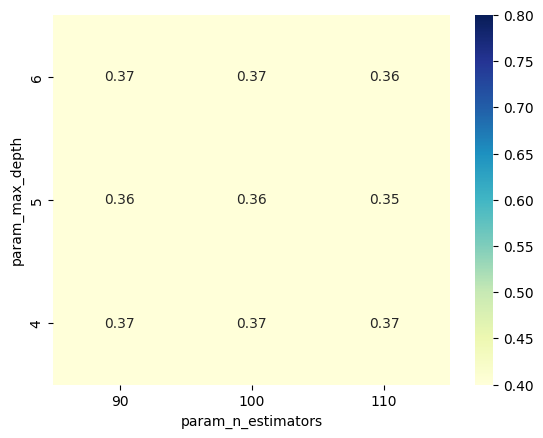

In [16]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.4,
                 vmax=0.8)
ax.invert_yaxis()

In [17]:
#run XGBoost model
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

xgb_pipeline = xgb.XGBRegressor(learning_rate=0.06,n_estimators=90,max_depth=6)

evaluate(xgb_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     2.778 +/- 0.541
Root Mean Squared Error: 3.966 +/- 0.815


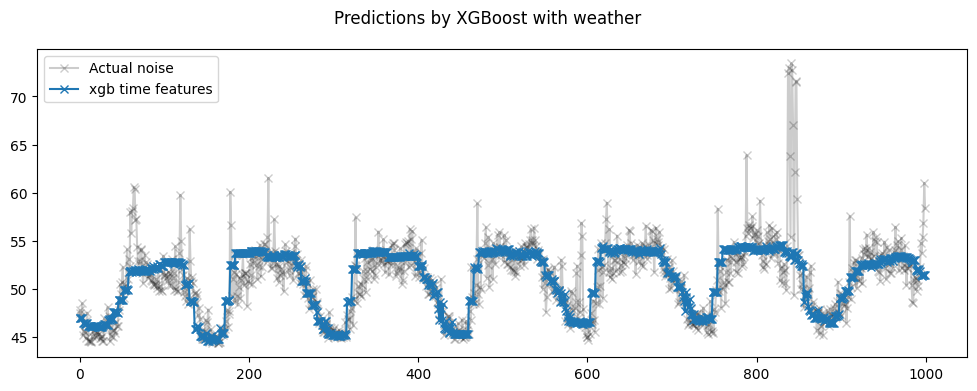

In [71]:
#Qualitative analysis of the impact of features on linear model predictions
xgb_pipeline.fit(X, y)
xgb_predictions = xgb_pipeline.predict(X)

last_hours = slice(-1000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by XGBoost with weather")
ax.plot(
    y.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(xgb_predictions[last_hours], "x-", label="xgb time features")
_ = ax.legend()


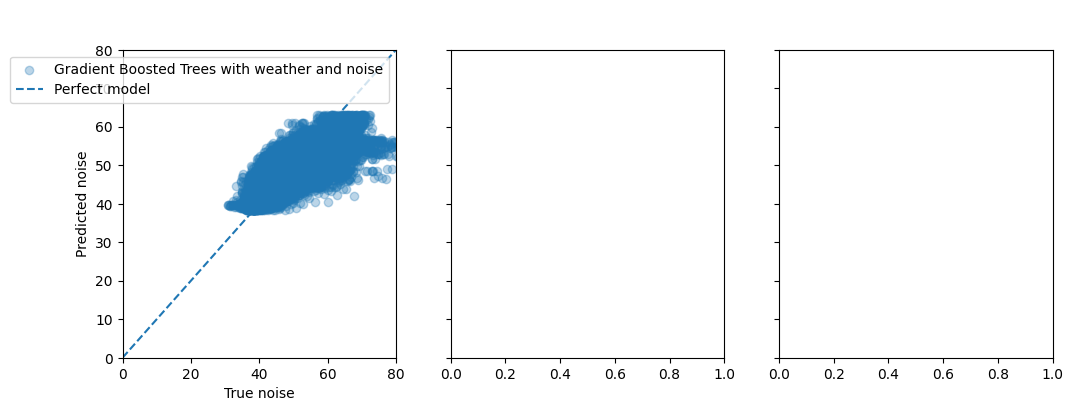

In [72]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle(" ")
predictions = [
    xgb_predictions,
]
labels = [
    "Gradient Boosted Trees with weather and noise",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True noise",
        ylabel="Predicted noise",
    )
    ax.legend()

plt.show()

In [73]:
#now do the same but look at variables separately: 
# the feature importance should be lower, because dropping a variable form the model 
# will not result in a large decrease of information gain, etc if the other correlated variables take over the task of explaining the model 
#example: you can see that weekend is not as important anymore, because day takes over if weekend is in the model
features=['hour','weekday','month','weekend','holiday','exam_period','LC_HUMIDITY','LC_DWPTEMP','LC_n',
          'LC_RAD','LC_RAININ','LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0']
imp = importances(gbrt_pipeline, X, y, features=features) # permutation
#should be on fitted model. I used the X and y but usualy you would need to use the validation set
viz = plot_importances(imp)
viz.view()

NameError: name 'importances' is not defined

In [74]:
df

,object_id,result_timestamp,laeq,date,time,hour,weekday,month,weekend,day_time,...,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
0,255441,2022-01-01 06:00:00,46.043333,2022-01-01,06:00:00,6,Saturday,1,True,Saturday 06:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,255441,2022-01-01 06:10:00,45.743000,2022-01-01,06:10:00,6,Saturday,1,True,Saturday 06:10:00,...,91.0,11.88,38.0,0.0,0.0,0.000,-48.0,0.04,0.0,13.28
2,255441,2022-01-01 06:20:00,48.452167,2022-01-01,06:20:00,6,Saturday,1,True,Saturday 06:20:00,...,90.0,11.72,37.0,0.0,0.0,0.000,45.0,0.02,0.0,13.28
3,255441,2022-01-01 06:30:00,45.736167,2022-01-01,06:30:00,6,Saturday,1,True,Saturday 06:30:00,...,90.0,11.72,38.0,0.0,0.0,0.000,-52.0,0.04,0.0,13.28
4,255441,2022-01-01 06:40:00,44.955333,2022-01-01,06:40:00,6,Saturday,1,True,Saturday 06:40:00,...,90.0,11.72,37.0,0.0,0.0,0.000,34.0,0.02,0.0,13.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131013,255441,2022-12-31 23:10:00,53.712833,2022-12-31,23:10:00,23,Saturday,12,True,Saturday 23:10:00,...,65.0,9.48,38.0,0.0,0.0,0.001,-28.0,0.17,0.0,15.95
131014,255441,2022-12-31 23:20:00,55.333167,2022-12-31,23:20:00,23,Saturday,12,True,Saturday 23:20:00,...,66.0,9.50,37.0,0.0,0.0,0.001,38.0,0.31,0.0,15.89
131015,255441,2022-12-31 23:30:00,56.797333,2022-12-31,23:30:00,23,Saturday,12,True,Saturday 23:30:00,...,66.0,9.43,38.0,0.0,0.0,0.001,46.0,0.26,0.0,15.79
131016,255441,2022-12-31 23:40:00,61.010667,2022-12-31,23:40:00,23,Saturday,12,True,Saturday 23:40:00,...,65.0,9.19,37.0,0.0,0.0,0.001,10.0,0.39,0.0,15.78


In [75]:
#predict nighttime values only
df_night = df.set_index('result_timestamp')

In [76]:
df_night = df_night.between_time(start_time='22:00:00', end_time='6:00:00', inclusive='left')
df_night = df_night.reset_index()
df_nd_n = df_night.drop(['key','object_id','result_timestamp','date','time','day_time','day_hour','LC_TEMP_QCL1','LC_TEMP_QCL2','LC_TEMP_QCL3'], axis=1)

In [77]:
df_nd_n = df_nd_n[df_nd_n.isna()['LC_HUMIDITY']==False]
df_nd_n.isna().sum()

laeq            0
hour            0
weekday         0
month           0
weekend         0
holiday         0
exam_period     0
255439          0
255440          0
255441          0
laeq_delayed    0
LC_HUMIDITY     0
LC_DWPTEMP      0
LC_n            0
LC_RAD          0
LC_RAININ       0
LC_DAILYRAIN    0
LC_WINDDIR      0
LC_WINDSPEED    0
LC_RAD60        0
LC_TEMP_QCL0    0
dtype: int64

In [78]:
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Monday', value=0)
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Tuesday', value=1)
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Wednesday', value=2)
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Thursday', value=3)
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Friday', value=4)
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Saturday', value=5)
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Sunday', value=6)

In [79]:
y_night = df_nd_n["laeq"]
X_night = df_nd_n.drop("laeq", axis="columns")

In [83]:
predictions = xgb_pipeline.predict(X_night)
predictions

array([51.938446, 52.11555 , 52.11555 , ..., 51.395412, 51.440113,
       51.440113], dtype=float32)

In [84]:
MAE = sum(((predictions-y_night)**2)**(1/2))/len(y_night)
MAE

2.2288501587426275

In [85]:
RMSE = (sum((predictions-y_night)**2)/len(y_night))**(1/2)
RMSE

3.1293852565058216